# Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from xgboost import XGBClassifier

# Load data

In [60]:
df = pd.read_csv(r"C:\Users\leege\Documents\Capstone\elderly_conversational_sentences_new.csv")
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 1 else 0)

# Remove '?' to generalize model
question_idx = df[df['text'].str.endswith('?')].index
remove_idx = np.random.choice(question_idx, size=len(question_idx)//2, replace=False)
df.loc[remove_idx, 'text'] = df.loc[remove_idx, 'text'].apply(lambda x: x.rstrip('?'))

print(df['category'].value_counts())
df['binary_label'].value_counts()

category
health_hobbies             573
community_events           558
food_and_meals             435
malay_cultural_events      399
family_interactions        399
market_shopping            392
chinese_cultural_events    350
indian_cultural_events     300
public_transport           300
Name: count, dtype: int64


binary_label
0    2211
1    1495
Name: count, dtype: int64

In [65]:
from dotenv import load_dotenv
import os

load_dotenv() 
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")


# Feature Extraction

In [61]:
# Feature Extraction with tf-idf
X_text = df['text'].values
y = df['binary_label'].values

# TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(X_text).toarray()

# SBERT embeddings
# all-MiniLM-L6-v2 or all-mpnet-base-v2
sbert_model = SentenceTransformer('google/embeddinggemma-300m')
X_sbert = sbert_model.encode(X_text, show_progress_bar=True)

# Simple NLP features
question_words = ['who','what','where','when','why','how','which']
def extract_simple_nlp_features(text):
    words = text.lower().split()
    return np.array([
        int(text.lower().endswith('?')),                      
        int(words[0] in question_words if words else 0)
    ])
X_nlp = np.array([extract_simple_nlp_features(t) for t in X_text])

# Combine all features
X_hybrid = np.hstack([X_tfidf, X_sbert, X_nlp])
print("Hybrid feature shape:", X_hybrid.shape)

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

Hybrid feature shape: (3706, 1270)


# Training

In [ ]:
# Logistic 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train/Validation/Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_hybrid, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

# Logistic Regression with Regularization
log_reg = LogisticRegression(
    C=1.0,                 # adjust for stronger/weaker regularization
    penalty="l2",          # L2 regularization (default)
    solver="lbfgs",        # supports multinomial
    max_iter=2000,         # increase for convergence on large data
    random_state=42
)

log_reg.fit(X_train, y_train)

# Evaluation


Test Accuracy: 0.9962599345488546

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1264
           1       1.00      0.99      1.00       875

    accuracy                           1.00      2139
   macro avg       1.00      1.00      1.00      2139
weighted avg       1.00      1.00      1.00      2139

F1 per class: [0.99684044 0.9954181 ]
Macro F1: 0.9961292704244773
Micro F1: 0.9962599345488546
Weighted F1: 0.9962586046341027


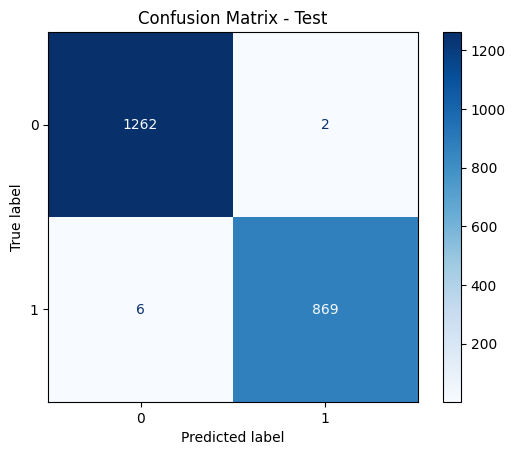

In [9]:
# Evaluation
y_test_pred = log_reg.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

from sklearn.metrics import f1_score
f1_per_class = f1_score(y_test, y_test_pred, average=None)
print("F1 per class:", f1_per_class)

# Macro, Micro, Weighted
f1_macro = f1_score(y_test, y_test_pred, average="macro")
f1_micro = f1_score(y_test, y_test_pred, average="micro")
f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

print("Macro F1:", f1_macro)
print("Micro F1:", f1_micro)
print("Weighted F1:", f1_weighted)
# Confusion Matrix - Test
cm_test = confusion_matrix(y_test, y_test_pred, labels=log_reg.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=log_reg.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test")
plt.show()

In [ ]:
import numpy as np

# Assume stack_model is your trained StackingClassifier
def predict_text(new_texts):
    """
    Input: list of strings
    Output: predicted labels using stacked model (0=statement, 1=question)
    """

    # Simple NLP features
    question_words = ['who','what','where','when','why','how','which']
    def extract_simple_nlp_features(text):
        words = text.lower().split()
        return np.array([
            int(text.lower().endswith('?')),                      
            int(words[0] in question_words if words else 0)
        ])
    
    # Transform features
    X_tfidf_new = tfidf_vectorizer.transform(new_texts).toarray()
    X_sbert_new = sbert_model.encode(new_texts, show_progress_bar=False)
    X_nlp_new = np.array([extract_simple_nlp_features(t) for t in new_texts])
    
    # Combine all features
    X_new_hybrid = np.hstack([X_tfidf_new, X_sbert_new, X_nlp_new])
    
    # Predict using stacked model
    preds = log_reg.predict(X_new_hybrid)
    return preds

predict_text(["should i eat more chicken wing"])


c:\Users\leege\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [11]:
import pandas as pd

# Extended test data with 20 samples
data = {
    "text": [
        "Did you take your kopi from the kopitiam today",
        "I remember when we used to walk to the hawker centre after school.",
        "Can you help me top up my EZ-Link card",
        "My knees have been hurting after walking at the park connector.",
        "What time is the doctor’s appointment at NUH tomorrow",
        "I enjoy watering the plants in my HDB balcony every morning.",
        "Have you seen the news about the MRT delay this morning",
        "I baked some pineapple tarts yesterday for CNY.",
        "Do you know how to set the aircon timer properly",
        "I like listening to old getai songs during the festive season.",
        "Why did the bus arrive late at the bus stop near Bedok?",
        "I feel tired after walking around the wet market.",
        "Could you remind me of your birthday again so I can send angbao",
        "I watched a really interesting documentary on Singapore’s history.",
        "When are we visiting the grandchildren at Changi next",
        "Did you manage to book a slot at the community centre for exercise",
        "I miss the old hawker uncle at our neighbourhood market.",
        "Can you teach me how to use WhatsApp video call",
        "I went for a morning stroll along East Coast Park today.",
        "Have you checked the weather before heading to the pasar malam tonight"
    ],
    "label": [  # 1 = question, 0 = statement
        1, 0, 1, 0, 1,
        0, 1, 0, 1, 0,
        1, 0, 1, 0, 1,
        1, 0, 1, 0, 1
    ]
}

df_test = pd.DataFrame(data)

# Assuming predict_text function exists
df_test['pred'] = df_test['text'].apply(lambda x: predict_text([x]))
pd.set_option('display.max_colwidth', None)
df_test


,text,label,pred
0,Did you take your kopi from the kopitiam today,1,[1]
1,I remember when we used to walk to the hawker centre after school.,0,[0]
2,Can you help me top up my EZ-Link card,1,[1]
3,My knees have been hurting after walking at the park connector.,0,[0]
4,What time is the doctor’s appointment at NUH tomorrow,1,[1]
5,I enjoy watering the plants in my HDB balcony every morning.,0,[0]
6,Have you seen the news about the MRT delay this morning,1,[1]
7,I baked some pineapple tarts yesterday for CNY.,0,[0]
8,Do you know how to set the aircon timer properly,1,[1]
9,I like listening to old getai songs during the festive season.,0,[0]


# Save model (Change directory accordingly)

In [64]:
# Save models
with open("../model_weights/qa_log_reg_hybrid_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

with open("../model_weights/qa_tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("../model_weights/qa_sbert_model_name.pkl", "wb") as f:
    pickle.dump('google/embeddinggemma-300m', f)

with open("../model_weights/qa_stacked_hybrid_model.pkl", "wb") as f:
    pickle.dump(stack_model, f)

print("Models and artifacts saved.")


Models and artifacts saved.


# Randomized Search - Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 1. Parameter grid (you can expand ranges)
param_dist = {
    'n_estimators': randint(100, 600),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.5, 2)
}

# 2. Base XGBoost classifier
xgb_model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# 3. Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=15,  # number of random combinations to try
    scoring='accuracy',
    cv=3,       # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 4. Fit to training data
random_search.fit(X_train, y_train)

# 5. Best parameters and score
print("Best parameters found:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

# 6. Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
from sklearn.metrics import accuracy_score
print("Test accuracy:", accuracy_score(y_test, y_pred))


# Benchmark speed and results against other models

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import pickle
import os
import time
from collections import OrderedDict

# Train/Validation/Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_hybrid, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

# Baseline Models
models = OrderedDict()

# Add the stacked model first
estimators = [
    ('lgbm', LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, verbose=-1)),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity=0)),
    ('lr_base', LogisticRegression(max_iter=500, solver='lbfgs', random_state=42))
]

stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500, solver='lbfgs', random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

models['Stacked_LGBM_XGB_LR'] = stacked_model

# Then add the rest of the baseline models
models.update({
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, verbose=-1),
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, solver="lbfgs", random_state=42),
    "SVM": SVC(kernel="linear", C=1.0, probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, use_label_encoder=False,
                             eval_metric='mlogloss', random_state=42, verbosity=0)
})

# Train, Evaluate, Measure Size & Time
all_reports = {}
size_dict = {}
time_dict = {}

for name, model in models.items():
    # Train
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    
    # Predict on validation
    start_pred = time.perf_counter()
    y_val_pred = model.predict(X_val)
    end_pred = time.perf_counter()
    
    # Accuracy & report
    acc = accuracy_score(y_val, y_val_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    
    report = classification_report(y_val, y_val_pred, output_dict=True)
    all_reports[name] = report
    
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_val, y_val_pred))
    
    # Measure size by saving temporarily with pickle
    tmp_file = f"tmp_{name}.pkl"
    with open(tmp_file, "wb") as f:
        pickle.dump(model, f)
    size_mb = os.path.getsize(tmp_file) / (1024 * 1024)
    size_dict[name] = size_mb
    os.remove(tmp_file)
    
    # Inference time per sample (on validation set)
    inference_time_per_sample = (end_pred - start_pred) / len(X_val)
    time_dict[name] = inference_time_per_sample
    
    print(f"{name} Model Size: {size_mb:.2f} MB")
    print(f"{name} Inference Time per Sample: {inference_time_per_sample:.10f} sec\n")

# Macro-Averaged Comparison
df_reports = pd.DataFrame({model: all_reports[model]["macro avg"] 
                           for model in all_reports}).T
df_reports = df_reports[["precision", "recall", "f1-score"]]

# Add model size and inference time
df_reports["model_size_MB"] = pd.Series(size_dict)
df_reports["inference_time_sec"] = pd.Series(time_dict)

print("\n\n====== Macro-Averaged Comparison Across Baseline Models ======")
display(df_reports)


c:\Users\leege\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Stacked_LGBM_XGB_LR Validation Accuracy: 0.9973

Classification Report for Stacked_LGBM_XGB_LR:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       442
           1       1.00      1.00      1.00       299

    accuracy                           1.00       741
   macro avg       1.00      1.00      1.00       741
weighted avg       1.00      1.00      1.00       741

Stacked_LGBM_XGB_LR Model Size: 0.24 MB
Stacked_LGBM_XGB_LR Inference Time per Sample: 0.0000941888 sec



c:\Users\leege\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Validation Accuracy: 0.9798

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       442
           1       1.00      0.95      0.97       299

    accuracy                           0.98       741
   macro avg       0.98      0.98      0.98       741
weighted avg       0.98      0.98      0.98       741

LightGBM Model Size: 0.10 MB
LightGBM Inference Time per Sample: 0.0000157973 sec

RandomForest Validation Accuracy: 0.9676

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       442
           1       1.00      0.92      0.96       299

    accuracy                           0.97       741
   macro avg       0.97      0.96      0.97       741
weighted avg       0.97      0.97      0.97       741

RandomForest Model Size: 0.21 MB
RandomForest Inference Time per Sample: 0.0000204076 sec

GradientBoosting

,precision,recall,f1-score,model_size_MB,inference_time_sec
Stacked_LGBM_XGB_LR,0.997197,0.997197,0.997197,0.236965,0.000094
LightGBM,0.982867,0.975457,0.978818,0.104100,0.000016
RandomForest,0.974249,0.959866,0.965878,0.214128,0.000020
GradientBoosting,0.978619,0.968768,0.973105,0.066453,0.000013
LogisticRegression,0.994407,0.991639,0.992972,0.010377,0.000005
SVM,0.998871,0.998328,0.998598,3.146761,0.000240
KNN,0.968240,0.959227,0.963219,21.556990,0.000256
NaiveBayes,0.913105,0.927208,0.916274,0.039316,0.000047
XGBoost,0.982867,0.975457,0.978818,0.057157,0.000017


In [7]:
pd.reset_option('display.float_format')

# Format only inference_time_sec
styled_df = df_reports.style.format({
    'inference_time_sec': '{:.2e}'
})

display(styled_df)

,precision,recall,f1-score,model_size_MB,inference_time_sec
LightGBM,0.988905,0.985099,0.986896,0.109469,1.02e-05
RandomForest,0.981827,0.973319,0.977084,0.215197,2.67e-05
GradientBoosting,0.988521,0.984528,0.986408,0.066590,1.08e-05
LogisticRegression,0.997061,0.996176,0.996613,0.010377,2.47e-06
SVM,0.998637,0.998462,0.998549,3.593348,2.84e-04
KNN,0.970582,0.966550,0.968441,62.216345,3.92e-04
NaiveBayes,0.930362,0.943038,0.933513,0.039316,5.85e-05
XGBoost,0.988350,0.983780,0.985915,0.058128,1.16e-05


# Stacking

c:\Users\leege\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Stacked Ensemble ---
Accuracy: 0.9971949509116409
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1264
           1       1.00      0.99      1.00       875

    accuracy                           1.00      2139
   macro avg       1.00      1.00      1.00      2139
weighted avg       1.00      1.00      1.00      2139



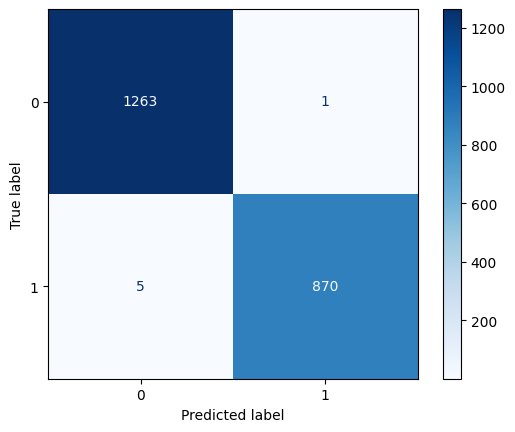

Stacked model approximate size: 2.08 MB
Inference time per sample: 22.24 ms
Predictions: [1 0]


c:\Users\leege\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Predictions via function: [1 0]


c:\Users\leege\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import joblib
import os
import time
import matplotlib.pyplot as plt

# -----------------------------
# Define base models
# -----------------------------
log_reg = LogisticRegression(
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
    random_state=42
)

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

lgbm_model = LGBMClassifier(
    n_estimators=500,
    max_depth=-1,
    learning_rate=0.05,
    random_state=42
)

# -----------------------------
# Stacked model
# -----------------------------
stack_model = StackingClassifier(
    estimators=[
        ('lr', log_reg),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    n_jobs=3,
    passthrough=True
)

stack_model.fit(X_train, y_train)

# -----------------------------
# Evaluate on validation set
# -----------------------------
y_pred_stack = stack_model.predict(X_val)
print("--- Stacked Ensemble ---")
print("Accuracy:", accuracy_score(y_val, y_pred_stack))
print(classification_report(y_val, y_pred_stack))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# -----------------------------
# Model diagnostics
# -----------------------------
def model_diagnostics_no_pympler(new_texts, X_new_hybrid, model=stack_model, temp_path="temp_stack_model.pkl"):
    # Save model to disk temporarily to estimate size
    joblib.dump(model, temp_path)
    size_mb = os.path.getsize(temp_path) / 1e6
    print(f"Stacked model approximate size: {size_mb:.2f} MB")
    os.remove(temp_path)
    
    # Measure inference time
    start_time = time.time()
    preds = model.predict(X_new_hybrid)
    end_time = time.time()
    time_per_sample = (end_time - start_time) / len(new_texts)
    print(f"Inference time per sample: {time_per_sample*1000:.2f} ms")
    
    return preds

# -----------------------------
# Predict function using stacked model
# -----------------------------
def predict_text(new_texts):
    """
    Input: list of strings
    Output: predicted labels using stacked model (0=statement, 1=question)
    """
    # Simple NLP features
    question_words = ['who','what','where','when','why','how','which']
    def extract_simple_nlp_features(text):
        words = text.lower().split()
        return np.array([
            int(text.lower().endswith('?')),                      
            int(words[0] in question_words if words else 0)
        ])
    
    # Transform features
    X_tfidf_new = tfidf_vectorizer.transform(new_texts).toarray()
    X_sbert_new = sbert_model.encode(new_texts, show_progress_bar=False)
    X_nlp_new = np.array([extract_simple_nlp_features(t) for t in new_texts])
    
    # Combine all features
    X_new_hybrid = np.hstack([X_tfidf_new, X_sbert_new, X_nlp_new])
    
    # Predict using stacked model
    preds = stack_model.predict(X_new_hybrid)
    return preds

# -----------------------------
# Example usage
# -----------------------------
new_texts = ["should I eat more chicken rice today?", "I love walking at East Coast Park."]
X_tfidf_new = tfidf_vectorizer.transform(new_texts).toarray()
X_sbert_new = sbert_model.encode(new_texts, show_progress_bar=False)
X_nlp_new = np.array([[int(t.lower().endswith('?')), int(t.lower().split()[0] in ['who','what','where','when','why','how','which'] if t.split() else 0)] for t in new_texts])
X_new_hybrid = np.hstack([X_tfidf_new, X_sbert_new, X_nlp_new])

preds = model_diagnostics_no_pympler(new_texts, X_new_hybrid)
print("Predictions:", preds)

# Direct prediction using predict_text
print("Predictions via function:", predict_text(new_texts))
